- <a href='#1'>Prepare</a>  
- <a href='#2'>Feature Selection</a>
    - <a href='#2-1'>1. Filter</a>
        - <a href='#2-1-1'>1.1 Pearson Correlation</a>
        - <a href='#2-1-2'>1.2 Chi-2</a>
    - <a href='#2-2'>2. Wrapper</a>
    - <a href='#2-3'>3. Embeded</a>
        - <a href='#2-3-1'>3.1 Logistics Regression L1</a>
        - <a href='#2-3-2'>3.2 Random Forest</a>
        - <a href='#2-3-3'>3.3 LightGBM</a>
- <a href='#3'>Summary</a>

# <a id='1'>Prepare</a>

In [1]:
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings("ignore")
application = pd.read_csv('C:\\Users\\momar\\OneDrive - Queen Mary, University of London\\MSc Project\\Home Credit Data\\Aggregated.csv')

### Stratified Sampling (ratio = 0.1)

In [2]:
application_sample1 = application_train.loc[application_train.TARGET==1].sample(frac=0.1, replace=False)
print('label 1 sample size:', str(application_sample1.shape[0]))
application_sample0 = application_train.loc[application_train.TARGET==0].sample(frac=0.1, replace=False)
print('label 0 sample size:', str(application_sample0.shape[0]))
application = pd.concat([application_sample1, application_sample0], axis=0).sort_values('SK_ID_CURR')

label 1 sample size: 2482
label 0 sample size: 28268


### Impute missing values

In [2]:
categorical_list = []
numerical_list = []
for i in application.columns.tolist():
    if application[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 0
Number of numerical features: 721


In [3]:
#from sklearn.preprocessing import Imputer
#application[numerical_list] = Imputer(strategy='median').fit_transform(application[numerical_list])

### Deal with Categorical features: OneHotEncoding

In [11]:
#del application_train; gc.collect()
#application = pd.get_dummies(application, drop_first=True)
print(application.shape)

(307507, 721)


### Feature matrix and target

In [2]:
with pd.option_context('mode.use_inf_as_null', True):
    X = application.dropna(axis='columns').drop(['SK_ID_CURR', 'TARGET', 'Unnamed: 0'], axis=1)
y = application.TARGET
#feature_name = X.columns.tolist()

In [25]:
#print(application.shape)
print(X.shape)
#print(y.shape)

(307507, 235)


# <a id='2'>Feature Selection</a>
- select **100** features from 226
- **xxx_support**: list to represent select this feature or not
- **xxx_feature**: the name of selected features

## <a id='2-1'>1 Filter</a>
- documentation for **SelectKBest**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

###  <a id='2-1-1'>1.1 Pearson Correlation</a>
**Note**
- Normalization: no
- Impute missing values: yes

In [26]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [27]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


###  <a id='2-1-2'>1.2 Chi-2</a>

**Note**
- Normalization: MinMaxScaler (values should be bigger than 0)
- Impute missing values: yes

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
try:
    X_norm = MinMaxScaler().fit_transform(X)
except ValueError:
    print('Value Error')
    
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x000001DF28D78730>)

In [30]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


## <a id='2-2'>2. Wrapper</a>
- documentation for **RFE**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

**Note**
- Normalization: depend on the used model; yes for LR
- Impute missing values: depend on the used model; yes for LR


In [31]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 235 features.
Fitting estimator with 225 features.
Fitting estimator with 215 features.
Fitting estimator with 205 features.
Fitting estimator with 195 features.
Fitting estimator with 185 features.
Fitting estimator with 175 features.
Fitting estimator with 165 features.
Fitting estimator with 155 features.
Fitting estimator with 145 features.
Fitting estimator with 135 features.
Fitting estimator with 125 features.
Fitting estimator with 115 features.
Fitting estimator with 105 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=100, step=10, verbose=5)

In [32]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
predicted = rfe_selector.predict()

100 selected features


## <a id='2-3'>3. Embeded</a>
- documentation for **SelectFromModel**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
###  <a id='2-3-1'>3.1 Logistics Regression L1</a>
**Note**
- Normalization: Yes
- Impute missing values: Yes

In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='1.25*median')

In [34]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

100 selected features


###  <a id='2-3-2'>3.2 Random Forest</a>
**Note**
- Normalization: No
- Impute missing values: Yes

In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold='1.25*median')

In [36]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

114 selected features


###  <a id='2-3-3'>3.3 LightGBM</a>
**Note**
- Normalization: No
- Impute missing values: No

In [37]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.2,
        learning_rate=0.05, max_depth=-1, min_child_samples=20,
        min_child_weight=40, min_split_gain=0.01, n_estimators=500,
        n_jobs=-1, num_leaves=32, objective=None, random_state=None,
        reg_alpha=3, reg_lambda=1, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
        norm_order=1, prefit=False, threshold='1.25*median')

In [38]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

102 selected features


# <a id='3'>Summary</a>

In [39]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

Feature  Pearson  Chi-2    RFE  \
1                          REGION_RATING_CLIENT_W_CITY     True   True   True   
2                                 REGION_RATING_CLIENT     True   True   True   
3                                     NEW_SOURCES_PROD     True   True   True   
4                             NEW_PHONE_TO_BIRTH_RATIO     True   True   True   
5                                       NEW_INC_BY_ORG     True   True   True   
6                                 NEW_EXT_SOURCES_MEAN     True   True   True   
7                            NEW_EMPLOY_TO_BIRTH_RATIO     True   True   True   
8                                       FLOORSMAX_MODE     True   True   True   
9                                      FLAG_WORK_PHONE     True   True   True   
10                                        FLAG_OWN_CAR     True   True   True   
11                                        EXT_SOURCE_3     True   True   True   
12                                        EXT_SOURCE_2     True   True   True   
13                                        EXT_SOURCE_1     True   True   True   
14                            DEF_60_CNT_SOCIAL_CIRCLE     True   True   True   
15                            DEF_30_CNT_SOCIAL_CIRCLE     True   True   True   
16                                   DAYS_REGISTRATION     True   True   True   
17                                     DAYS_ID_PUBLISH     True   True   True   
18                                       DAYS_EMPLOYED     True   True   True   
19                                          DAYS_BIRTH     True   True   True   
20                                         CODE_GENDER     True   True   True   
21                                     AMT_GOODS_PRICE     True   True   True   
22                                          AMT_CREDIT     True   True   True   
23                              REG_CITY_NOT_LIVE_CITY     True   True  False   
24                                         OWN_CAR_AGE     True  False   True   
25                 ORGANIZATION_TYPE_Transport: type 3     True   True   True   
26                     ORGANIZATION_TYPE_Self-employed     True   True  False   
27                             OCCUPATION_TYPE_Drivers     True   True  False   
28                                    NEW_LIVE_IND_SUM     True  False   True   
29                                    NEW_INC_PER_CHLD     True  False   True   
30                                    NEW_DOC_IND_KURT     True   True   True   
31                           NEW_CREDIT_TO_GOODS_RATIO     True  False   True   
32                              NEW_CAR_TO_BIRTH_RATIO     True  False   True   
33                         NEW_ANNUITY_TO_INCOME_RATIO     True  False   True   
34                            NAME_INCOME_TYPE_Working     True   True   True   
35                          NAME_FAMILY_STATUS_Married     True   True  False   
36   NAME_EDUCATION_TYPE_Secondary / secondary special     True   True   True   
37                NAME_EDUCATION_TYPE_Higher education     True   True  False   
38                       NAME_CONTRACT_TYPE_Cash loans     True   True   True   
39                               LIVINGAPARTMENTS_MEDI     True  False   True   
40                                     FLAG_DOCUMENT_3     True   True  False   
41                                      ENTRANCES_MEDI     True  False   True   
42                                      ELEVATORS_MODE     True   True   True   
43                                        CNT_CHILDREN     True  False   True   
44                          AMT_REQ_CREDIT_BUREAU_YEAR     True  False   True   
45                                         AMT_ANNUITY     True  False   True   
46                                    YEARS_BUILD_MODE    False  False   True   
47                        YEARS_BEGINEXPLUATATION_MEDI    False  False   True   
48                              REG_CITY_NOT_WORK_CITY     True   True  False   
49                          REGION_POPULATION_RELATIVE     True   True  False 

In [37]:
#feature_selection_df.to_csv('100FeatureSelection.csv')
#del feature_selection_df, application
#gc.collect()
fs1 = pd.read_csv('100FeatureSelection.csv')
#FS_df = X[fs1['Feature']]
fs1.shape

(235, 9)

In [19]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

In [17]:
# Code for cross validation
def cross_validation(X, Y):
    num_fold = 10
    skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=2018)
    valid_scores = []
    train_scores = []
    
    for train_index, test_index in skf.split(X, Y):
        X_train, X_validation = X.iloc[train_index], X.iloc[test_index]
        y_train, y_validation = Y.iloc[train_index], Y.iloc[test_index]
        
        clf = LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=31,
            feature_fraction=0.8,
            subsample=0.8,
            max_depth=8,
            reg_alpha=1,
            reg_lambda=1,
            min_child_weight=40,
            random_state=2018,
            nthread=-1
            )
                   
        clf.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_validation, y_validation)], 
                eval_metric='auc',
                verbose = False,
                early_stopping_rounds=100
                )
        
        train_prediction = clf.predict_proba(X_train)[:, 1]
        train_score = roc_auc_score(y_train, train_prediction)
        train_scores.append(train_score)
        
        valid_prediction = clf.predict_proba(X_validation)[:, 1]
        valid_score = roc_auc_score(y_validation, valid_prediction)
        valid_scores.append(valid_score)
        
        print('Fold', num_fold, train_score, valid_score, clf.best_iteration_)
        num_fold = num_fold - 1
        
    print('AUC mean:', np.mean(valid_scores), 'std:',np.std(valid_scores))


In [35]:
cross_validation(X, y)

Fold 10 0.812634480439176 0.7681582099890205 188
Fold 9 0.8269712224312014 0.7709758274623234 271
Fold 8 0.8322233769383449 0.7692052525733071 301
Fold 7 0.8276940696885526 0.7703268172347967 278
Fold 6 0.8215941993985365 0.7638644209804539 238
Fold 5 0.8094169752403899 0.7677882423179452 170
Fold 4 0.8194007178561147 0.7728549903439474 228
Fold 3 0.8323629945990998 0.7805441716085262 311
Fold 2 0.8405524744543277 0.7667364925582206 357
Fold 1 0.8101481054335824 0.7657218715946266 176
AUC mean: 0.7696176296663169 std: 0.004409550794988882


In [32]:

# #############################################################################
# Classification and ROC analysis

def cross_validation_LR(train, train_labels):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)
    log_reg = LogisticRegression(C = 0.001, n_jobs = -1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for trainSet, testSet in cv.split(train, train_labels):
        probas_ = log_reg.fit(train.iloc[trainSet], train_labels.iloc[trainSet]).predict_proba(train.iloc[testSet])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(train_labels.iloc[testSet], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
                 #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        print(i)
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
#print(FS_df.head())
#y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

0
1
2
3
4
5
6
7
8
9


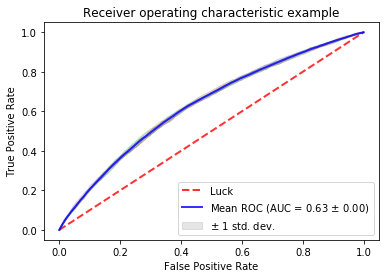

In [34]:
cross_validation_LR(X, y)